# Leonardo Lecci
### A1: Classification Model Development

## Objective

Apprentice Chef is looking to expand is business. To attract new customers, they have been conducting a cross-sell promotion for their customers.
They are now looking to develop a classification machine learning model the gain deeper insights to which type of customers their promotions would be more likely to have a positive outcome.
<br>
<br>
To develop this model we will use the dataset provided by them "Cross_Sell_Success_Dataset_2023.xlsx". Their data science team assures that their dataset engineering techniques are statistically sound and represent the true picture of Apprentice Chef’s customers. Taking this assumption as true, to build a better model we will only analyze the dataset to understand which engineering feature might be built to construct a more robust model.
<br>
<br>
To ensure we will use the best model possible we will create a model tournament on five models (Logistic Regression, Random Forest Classifier, Gradient Boosting Classifier, K Neighbors Classifier, and Decision Tree Classifier) to ensure to pick the best one for the task. The winner will be chosen based on the model whose AUC score is the highest.
<br>
<br>
AUC is particularly useful when the dataset is imbalanced, i.e., when one class is much rarer than the other. In such cases, accuracy alone may not be a good metric to use because a model that simply predicts the majority class all the time will have a high accuracy but may not be very useful in practice.
In addition, AUC takes into account both the true positive rate and the false positive rate, regardless of the class distribution. This makes it a more robust and reliable measure of the model's performance, especially when dealing with imbalanced datasets.

## Importing necessary libraries and data

In [1]:
#Import necessary libraries
import pandas                     as pd
import matplotlib.pyplot          as plt                                                                          # data visualization
import seaborn                    as sns                                                                          # enhanced data viz
import numpy                      as np
import time
from sklearn.model_selection      import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score      # train-test split, hyperparameter tuning and cross_val_score
from sklearn.linear_model         import LogisticRegression                                                       # logistic regression
from sklearn.ensemble             import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors            import KNeighborsClassifier
from sklearn.metrics              import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, make_scorer  # confusion matrix, auc score
from sklearn.neighbors            import KNeighborsClassifier                                                     # KNN for classification
from sklearn.preprocessing        import StandardScaler                                                           # standard scaler
from sklearn.tree                 import DecisionTreeClassifier, plot_tree                                        # classification trees, tree plots
from sklearn.pipeline             import Pipeline
from sklearn.decomposition        import PCA
import warnings
from scipy import stats

# suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)


# specifying the path and file name
file = './__datasets/Cross_Sell_Success_Dataset_2023.xlsx'


data = pd.read_excel(file)

# Feature Engineering

Feature engineering is the process of selecting, transforming, and creating new features from raw data to improve the performance of machine learning models. In other words, it's the process of selecting the most important variables or features from the data, as well as creating new variables that may capture important relationships in the data.
<br>
<br>
Feature engineering is important for classifier models in machine learning for several reasons. 
- First, selecting the right features can improve the accuracy and generalizability of the model. By removing irrelevant features and selecting only the most informative ones, the model can better capture the underlying patterns in the data and make better predictions.
- Second, feature engineering can help address common problems in classification tasks, such as overfitting or underfitting. By adding new features that capture important relationships in the data, or by transforming existing features to better capture non-linear relationships, the model can better fit the training data and generalize to new data.
- Finally, feature engineering can also help reduce the complexity of the model, making it easier to understand and interpret. By selecting only the most important features and transforming them in a meaningful way, the model can be more transparent and provide insights into the underlying relationships in the data.

In [2]:
# renaming the Mislabeled column to a name that better represent the data
data = data.rename(columns={'LARGEST_ORDER_SIZE': 'AVG_ORDER_SIZE', 'LATE_DELIVERIES ':'LATE_DELIVERIES'})

In [3]:
data["LATE_DELIVERY_DUMMY"] = (data['LATE_DELIVERIES']>0).astype(int) # get dummy if late delivery is bigger than one
data["CANCELLED_ORDER_DUMMY"] = (data['CANCELLATIONS_AFTER_NOON']>0).astype(int)
data["WEEKLY_PLAN_DUMMY"] = (data['WEEKLY_PLAN']>0).astype(int)
data['LOG_REVENUE'] = np.log(data['REVENUE']) 
data["LOG_TOTAL_MEALS_ORDERED"] = np.log(data['TOTAL_MEALS_ORDERED']) 
data["LOG_AVG_TIME_PER_SITE_VISIT"] = np.log(data['AVG_TIME_PER_SITE_VISIT']) 
data["LOG_AVG_PREP_VID_TIME"] = np.log(data['AVG_PREP_VID_TIME'])



### EMAIL FEATURE
We thought of this feature to help classify users based on the type of email they used to signup on to their accounts. We think that users with a professional email will have more probability to subscribe to the promotion for different reasons. It might be due to the fact that they check their work email more often, and the promotion of the company might have been communicated through marketing emails. Another reason might be that they have higher disposable income than people using personal, or, especially, junk emails, and therefore are more likely to take part in the promotion.

In [4]:
# create new columns with default value of 0
data['PROFESSIONAL'] = 0
data['PERSONAL'] = 0
data['JUNK'] = 0

# create lists of email domains for each category
professional_domains = ['mmm.com', 'amex.com', 'apple.com', 'boeing.com', 'caterpillar.com',
                        'chevron.com', 'cisco.com', 'cocacola.com', 'disney.com', 'dupont.com',
                        'exxon.com', 'ge.org', 'goldmansacs.com', 'homedepot.com', 'ibm.com',
                        'intel.com', 'jnj.com', 'jpmorgan.com', 'mcdonalds.com', 'merck.com',
                        'microsoft.com', 'nike.com', 'pfizer.com', 'pg.com', 'travelers.com',
                        'unitedtech.com', 'unitedhealth.com', 'verizon.com', 'visa.com', 'walmart.com']
personal_domains = ['gmail.com', 'yahoo.com', 'protonmail.com']
junk_domains = ['me.com', 'aol.com', 'hotmail.com', 'live.com', 'msn.com', 'passport.com']

# loop through each email and update the corresponding column
for index, row in data.iterrows():
    email = row['EMAIL']
    domain = email.split('@')[1]
    
    if domain in professional_domains:
        data.at[index, 'PROFESSIONAL'] = 1
    elif domain in personal_domains:
        data.at[index, 'PERSONAL'] = 1
    elif domain in junk_domains:
        data.at[index, 'JUNK'] = 1


### USER SIZE
This engineering feature is based on categorizing users based on the number of meals ordered.
The expected behavior is that large users (people with a higher level of orders), might be more inclined to take part in the promotion.
Although another possibility is that because the promotion was initially directed towards users that were not as engaged in the app, users with the least amount of orders might be the ones responding better to the cross-sell promotion.
<br>
To calculate this feature, we have created three new columns, each of them is a dummy variable, whose value will be set to 1 (instead of the default 0), if the value in the original column is respectively in the first quartile, interquartile range, and, finally, in the fourth quartile.

In [5]:
# describe for TOTAL_MEALS_ORDERED
data['TOTAL_MEALS_ORDERED'].describe(include = 'number').round(decimals = 2)

count    1946.00
mean       74.63
std        55.31
min        11.00
25%        39.00
50%        60.00
75%        95.00
max       493.00
Name: TOTAL_MEALS_ORDERED, dtype: float64

In [6]:
# calculating if a user is small, medium, or large based on the number of meals orderd
data['SMALL_USER'] = 0
data['MEDIUM_USER'] = 0
data['LARGE_USER'] = 0

# Creating a loop to fill
for index, row in data.iterrows():
    
    # small_customer
    if data.loc[index, 'TOTAL_MEALS_ORDERED'] < data['TOTAL_MEALS_ORDERED'].describe(include = 'number')['25%'].round(decimals = 0): # 25th percentile
        data.loc[index, 'SMALL_USER'] = 1   
     
    # medium_customer
    elif data.loc[index, 'TOTAL_MEALS_ORDERED'] >= data['TOTAL_MEALS_ORDERED'].describe(include = 'number')['25%'].round(decimals = 0) and data.loc[index, 'TOTAL_MEALS_ORDERED'] < data['TOTAL_MEALS_ORDERED'].describe(include = 'number')['75%'].round(decimals = 0): # in the IQR
        data.loc[index, 'MEDIUM_USER'] = 1
    
    # large_customer
    if data.loc[index, 'TOTAL_MEALS_ORDERED'] >= data['TOTAL_MEALS_ORDERED'].describe(include = 'number')['75%'].round(decimals = 0) : # above the 75th percentile
        data.loc[index, 'LARGE_USER'] = 1

### CONTACT TO CUSTOMER SERVICE
This engineering feature is creating three new binary variables, LOW_CONTACT, MEDIUM_CONTACT, and LARGE_CONTACT, based on the value of the CONTACTS_W_CUSTOMER_SERVICE feature. These variables will be used as inputs to a classifier machine learning model to predict a target variable.

The LOW_CONTACT variable is set to 1 if the value of CONTACTS_W_CUSTOMER_SERVICE is below the 25th percentile of the data, while the LARGE_CONTACT variable is set to 1 if the value is above the 75th percentile. The MEDIUM_CONTACT variable is set to 1 if the value is within the interquartile range (between the 25th and 75th percentile).

The for loop is iterating through each row of the data, and for each row, the CONTACTS_W_CUSTOMER_SERVICE value is compared to the percentiles of the distribution, and the appropriate binary variable is set to 1.

This feature engineering approach is useful for capturing non-linear relationships between the CONTACTS_W_CUSTOMER_SERVICE feature and the target variable, and it can help improve the performance of the classifier model.

In [7]:
# Descriptive statisctics for CONTACTS_W_CUSTOMER_SERVICE
data['CONTACTS_W_CUSTOMER_SERVICE'].describe(include = 'number').round(decimals = 2)

count    1946.0
mean        4.9
std         2.5
min         1.0
25%         3.0
50%         5.0
75%         7.0
max        19.0
Name: CONTACTS_W_CUSTOMER_SERVICE, dtype: float64

In [8]:
# Placeholder variables using percentiles
data['LOW_CONTACT'] = 0
data['MEDIUM_CONTACT'] = 0
data['LARGE_CONTACT'] = 0

# Creating a loop to fill
for index, row in data.iterrows():
    
    # low_contact
    if data.loc[index, 'CONTACTS_W_CUSTOMER_SERVICE'] < data['CONTACTS_W_CUSTOMER_SERVICE'].describe(include = 'number')['25%'].round(decimals = 0) : # 25th percentile
        data.loc[index, 'LOW_CONTACT'] = 1   
     
    # medium_contact
    elif data.loc[index, 'CONTACTS_W_CUSTOMER_SERVICE'] >= data['CONTACTS_W_CUSTOMER_SERVICE'].describe(include = 'number')['25%'].round(decimals = 0) and data.loc[index, 'CONTACTS_W_CUSTOMER_SERVICE'] < data['CONTACTS_W_CUSTOMER_SERVICE'].describe(include = 'number')['75%'].round(decimals = 0): # in the IQR
        data.loc[index, 'MEDIUM_CONTACT'] = 1
    
    # large_contact
    if data.loc[index, 'CONTACTS_W_CUSTOMER_SERVICE'] >= data['CONTACTS_W_CUSTOMER_SERVICE'].describe(include = 'number')['75%'].round(decimals = 0) : # above the 75th percentile
        data.loc[index, 'LARGE_CONTACT'] = 1

### TYPE OF USER RANKER
This engineering feature involves creating three placeholder variables, LOW_RANKING, MEDIUM_RANKING, and HIGH_RANKING, that will be used to classify data based on the distribution of the AVG_MEAN_RATING column. The code uses percentiles to determine which category each row of data falls into, with the 25th percentile used to define the low-ranking group, the 75th percentile used to define the high-ranking group, and the interquartile range used to define the medium-ranking group. The code then uses a loop to fill in the appropriate ranking value for each row of data based on its AVG_MEAN_RATING value. This feature can be used to classify data for further analysis or to train a machine learning model.

In [9]:
data['AVG_MEAN_RATING'].describe(include = 'number').round(decimals = 2)

count    1946.00
mean        3.55
std         0.61
min         1.32
25%         3.16
50%         3.42
75%         3.95
max         5.00
Name: AVG_MEAN_RATING, dtype: float64

In [10]:
# Placeholder variables using percentiles
data['LOW_RANKING'] = 0
data['MEDIUM_RANKING'] = 0
data['HIGH_RANKING'] = 0

# Creating a loop to fill
for index, row in data.iterrows():
    
    # low_contact
    if data.loc[index, 'AVG_MEAN_RATING'] < data['AVG_MEAN_RATING'].describe(include = 'number')['25%'].round(decimals = 2): # 25th percentile
        data.loc[index, 'LOW_RANKING'] = 1   
     
    # medium_contact
    elif data.loc[index, 'AVG_MEAN_RATING'] >= data['AVG_MEAN_RATING'].describe(include = 'number')['25%'].round(decimals = 2) and data.loc[index, 'AVG_MEAN_RATING'] < data['AVG_MEAN_RATING'].describe(include = 'number')['75%'].round(decimals = 2): # in the IQR
        data.loc[index, 'MEDIUM_RANKING'] = 1
    
    # large_contact
    if data.loc[index, 'AVG_MEAN_RATING'] >+ data['AVG_MEAN_RATING'].describe(include = 'number')['75%'].round(decimals = 2) : # above the 75th percentile
        data.loc[index, 'HIGH_RANKING'] = 1

### USER SPENDING
This engineering feature creates three new placeholder variables for a classifier machine learning model: LOW_SPENDER, MEDIUM_SPENDER, and HIGH_SPENDER. These variables are filled using percentiles of the REVENUE column in the data set.

The script uses a loop to iterate over each row in the data set, and sets the value of each placeholder variable based on the REVENUE value of that row. If the REVENUE value is below the 25th percentile, the LOW_SPENDER variable is set to 1. If the REVENUE value is between the 25th and 75th percentile, and the CONTACTS_W_CUSTOMER_SERVICE value is below the 75th percentile, the MEDIUM_SPENDER variable is set to 1. Finally, if the REVENUE value is above the 75th percentile, the HIGH_SPENDER variable is set to 1.

This engineering feature is useful for creating a classifier model that can predict the spending behavior of customers based on their revenue and customer service interactions. By dividing customers into three groups based on their spending behavior, the model can be used to target marketing efforts or identify areas for improvement in customer service.

In [11]:
data['REVENUE'].describe(include = 'number').round(decimals = 2)

count    1946.00
mean     2107.29
std      1138.29
min       131.00
25%      1350.00
50%      1740.00
75%      2670.00
max      8793.75
Name: REVENUE, dtype: float64

In [12]:
# Placeholder variables using percentiles
data['LOW_SPENDER'] = 0
data['MEDIUM_SPENDER'] = 0
data['HIGH_SPENDER'] = 0

# Creating a loop to fill
for index, row in data.iterrows():
    
    # low_buyer
    if data.loc[index, 'REVENUE'] < data['REVENUE'].describe(include = 'number')['25%'].round(decimals = 0): # 25th percentile
        data.loc[index, 'LOW_SPENDER'] = 1   
     
    # medium_buyer
    elif data.loc[index, 'REVENUE'] >= data['REVENUE'].describe(include = 'number')['25%'].round(decimals = 0) and data.loc[index, 'CONTACTS_W_CUSTOMER_SERVICE'] < data['REVENUE'].describe(include = 'number')['75%'].round(decimals = 0): # in the IQR
        data.loc[index, 'MEDIUM_SPENDER'] = 1
    
    # large_buyer
    if data.loc[index, 'REVENUE'] >= data['REVENUE'].describe(include = 'number')['75%'].round(decimals = 0) : # above the 75th percentile
        data.loc[index, 'HIGH_SPENDER'] = 1

In [13]:
col = ['UNIQUE_MEALS_PURCH', 'REVENUE', 'PRODUCT_CATEGORIES_VIEWED', 'PC_LOGINS',
       'MOBILE_LOGINS', 'AVG_ORDER_SIZE', 'TOTAL_PHOTOS_VIEWED', 'LOG_REVENUE', 
       'LATE_DELIVERY_DUMMY', 'CANCELLED_ORDER_DUMMY', 'WEEKLY_PLAN_DUMMY', 
       'LOG_AVG_TIME_PER_SITE_VISIT', 'LOG_AVG_PREP_VID_TIME', 'SMALL_USER',
       'MEDIUM_USER','LARGE_CONTACT', 'MEDIUM_CONTACT', 'LOW_RANKING', 'HIGH_RANKING',
       'PROFESSIONAL', 'JUNK', 'MEDIUM_SPENDER', 'HIGH_SPENDER']

In [14]:
#col = ['LOG_AVG_TIME_PER_SITE_VISIT', 'LOG_AVG_PREP_VID_TIME',
#       'TOTAL_PHOTOS_VIEWED', 'SMALL_USER', 'MEDIUM_USER','LARGE_CONTACT',
#        'MEDIUM_CONTACT', 'LOW_RANKING', 'HIGH_RANKING', 'PROFESSIONAL', 
#        'JUNK', 'MEDIUM_SPENDER', 'HIGH_SPENDER', 'REVENUE']

In [15]:
#col = ['SMALL_USER', 'MEDIUM_USER','LARGE_CONTACT', 'MEDIUM_CONTACT', 
#       'LOW_RANKING', 'HIGH_RANKING', 'PROFESSIONAL', 'JUNK', 'MEDIUM_SPENDER', 'HIGH_SPENDER', 'REVENUE']

In [16]:
data.corr()['CROSS_SELL_SUCCESS'].to_frame().sort_values("CROSS_SELL_SUCCESS", ascending = False)

,CROSS_SELL_SUCCESS
CROSS_SELL_SUCCESS,1.000000
PROFESSIONAL,0.194102
CANCELLATIONS_AFTER_NOON,0.142681
CANCELLED_ORDER_DUMMY,0.099748
MOBILE_LOGINS,0.062023
PC_LOGINS,0.044462
PERSONAL,0.038841
UNIQUE_MEALS_PURCH,0.036541
LOG_AVG_TIME_PER_SITE_VISIT,0.034529
MEDIUM_SPENDER,0.032705


In [17]:
#X = data.loc[:, col]
X = data.drop(['CROSS_SELL_SUCCESS', 'EMAIL'], axis = 1)
y = data.loc[ : , 'CROSS_SELL_SUCCESS']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=219, stratify=y)

data_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis = 1)

In [18]:
# scaling the independent variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# HYPERPARAMTERS TUNING

Hyperparameter tuning is the process of selecting the optimal set of hyperparameters for a machine learning model. Hyperparameters are parameters that are not learned by the model during training, but instead are set by the user before the training process begins. They can have a significant impact on the performance of the model.
<br>
<br>
In the context of a classifier model in machine learning, hyperparameter tuning is particularly important because the choice of hyperparameters can significantly affect the accuracy and generalization performance of the model. By carefully selecting the optimal set of hyperparameters, it is possible to improve the performance of the model and reduce the risk of overfitting.
<br>
<br>
Hyperparameter tuning can be a challenging and time-consuming process, as it often involves training and evaluating the model with different combinations of hyperparameters. However, it is an important step in the machine learning pipeline, as it can lead to significant improvements in the performance of the model.

In [19]:
# Set up scorer
scorer = make_scorer(roc_auc_score)

# Define pipeline steps
scaler = StandardScaler()
dtc    = DecisionTreeClassifier()
rfc    = RandomForestClassifier()
lr     = LogisticRegression(max_iter=1000)
gbc    = GradientBoostingClassifier()
knc    = KNeighborsClassifier()

# Define parameter grids
dtc_params = {'clf__criterion': ['gini', 'entropy'],
              'clf__max_depth': [2, 3, 4, 5, 6, 7, 8],
              'clf__min_samples_split': [2, 3, 4, 6, 8],
              'clf__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8]}
rfc_params = {'clf__n_estimators': [5, 6, 7, 8, 9, 10],
              'clf__max_depth': [2, 3, 4, 5, 6, 7, 8]}
lr_params  = {'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'clf__solver': ['liblinear', 'lbfgs', 'saga', 'newton-cg']}
gbc_params = {'clf__n_estimators': [5, 6, 7, 8, 9, 10],
              'clf__max_depth': [2, 3, 4, 5, 6, 7, 8],
              'clf__learning_rate': [0.05, 0.1, 0.2]}
knc_params = {'clf__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
              'clf__weights': ['uniform', 'distance'],
              'clf__p': [1, 2],
              'clf__leaf_size': [10, 30, 50, 100]}

# Define pipelines
dtc_pipe = Pipeline([('scaler', scaler), ('clf', dtc)])
rfc_pipe = Pipeline([('scaler', scaler), ('clf', rfc)])
lr_pipe  = Pipeline([('scaler', scaler), ('clf', lr)])
gbc_pipe = Pipeline([('scaler', scaler), ('clf', gbc)])
knc_pipe = Pipeline([('scaler', scaler), ('clf', knc)])

# Define hyperparameter grids for GridSearchCV
grid_params = [
    {'pipeline': dtc_pipe, 'params': dtc_params},
    {'pipeline': rfc_pipe, 'params': rfc_params},
    {'pipeline': lr_pipe, 'params': lr_params},
    {'pipeline': gbc_pipe, 'params': gbc_params},
    {'pipeline': knc_pipe, 'params': knc_params},
]


# Run GridSearchCV for each pipeline
best_params = {}
for params in grid_params:
    print(f"Starting grid search for {params['pipeline'].named_steps['clf']}...")
    start_time = time.time()
    gs = GridSearchCV(params['pipeline'], params['params'], scoring=scorer, cv=5)
    gs.fit(X_train, y_train)
    print(f"Best parameters: {gs.best_params_}")
    print(f"Best AUC score: {gs.best_score_:.4f}")
    print(f"Time elapsed: {time.time() - start_time:.2f} seconds\n")
    best_params[str(params['pipeline'].named_steps['clf'])] = gs.best_params_

Starting grid search for DecisionTreeClassifier()...
Best parameters: {'clf__criterion': 'gini', 'clf__max_depth': 3, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2}
Best AUC score: 0.6081
Time elapsed: 19.56 seconds

Starting grid search for RandomForestClassifier()...
Best parameters: {'clf__max_depth': 7, 'clf__n_estimators': 10}
Best AUC score: 0.5921
Time elapsed: 2.65 seconds

Starting grid search for LogisticRegression(max_iter=1000)...
Best parameters: {'clf__C': 0.1, 'clf__solver': 'liblinear'}
Best AUC score: 0.6192
Time elapsed: 2.81 seconds

Starting grid search for GradientBoostingClassifier()...
Best parameters: {'clf__learning_rate': 0.2, 'clf__max_depth': 2, 'clf__n_estimators': 5}
Best AUC score: 0.6051
Time elapsed: 31.32 seconds

Starting grid search for KNeighborsClassifier()...
Best parameters: {'clf__leaf_size': 10, 'clf__n_neighbors': 4, 'clf__p': 2, 'clf__weights': 'uniform'}
Best AUC score: 0.5722
Time elapsed: 20.52 seconds



## Developing Models

In [20]:
models    = {}
threshold = 0.65

### Logistic Regression

In [21]:
#Initialize the model
model_name = "Logistic Regression"
model = LogisticRegression(C           = best_params['LogisticRegression(max_iter=1000)']['clf__C'],
                           solver      = best_params['LogisticRegression(max_iter=1000)']['clf__solver'],
                           random_state=219)

#Fit the models
model_fit = model.fit(X_train, y_train)

#Predict on test data
#model_pred = model_fit.predict(X_test)

# get predicted probabilities
model_y_pred_probs = model_fit.predict_proba(X_test)
probs = model.predict_proba(X_test)[:, 1]

# classify based on adjusted threshold
model_pred = np.where(probs > threshold, 1, 0)

#calculate train and test score, and train-test gap
model_train_score = model_fit.score(X_train, y_train).round(4) # accuracy
model_test_score  = model_fit.score(X_test, y_test).round(4)   # accuracy
model_test_gap = abs(model_train_score - model_test_score).round(4)

# calculate auc score
model_auc = roc_auc_score(y_true  = y_test, y_score = model_pred).round(decimals = 4)

# confusion matrix
# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()

# save model and results in a dictionary in the dictionary "models"
models["lrc"] = {
    "model_type"     : model_name,
    "train_acc"      : model_train_score,
    "test_acc"       : model_test_score,
    "train_test_gap" : model_test_gap,
    "AUC_score"      : model_auc,
    "conf_matrix"    : {
        "tn" : model_tn,
        "fp" : model_fp,
        "fn" : model_fn,
        "tp" : model_tp
    },
    "winner"         : 0
}

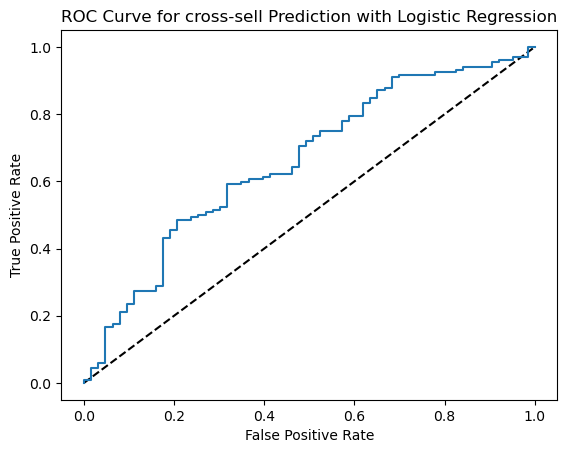

In [22]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for cross-sell Prediction with {model_name}')
plt.show()

### Decision Tree Classifier

In [23]:
#Initialize the model
model_name = "Decision Tree Classifier"
model = DecisionTreeClassifier(criterion = best_params['DecisionTreeClassifier()']['clf__criterion'],
                               max_depth = best_params['DecisionTreeClassifier()']['clf__max_depth'],
                               min_samples_leaf = best_params['DecisionTreeClassifier()']['clf__min_samples_leaf'],
                               min_samples_split = best_params['DecisionTreeClassifier()']['clf__min_samples_split'],
                               random_state=219)

#Fit the models
model_fit = model.fit(X_train, y_train)

#Predict on test data
#model_pred = model_fit.predict(X_test)

# get predicted probabilities
model_y_pred_probs = model_fit.predict_proba(X_test)
probs = model.predict_proba(X_test)[:, 1]

# classify based on adjusted threshold
model_pred = np.where(probs > threshold, 1, 0)

#calculate train and test score, and train-test gap
model_train_score = model_fit.score(X_train, y_train).round(4) # accuracy
model_test_score  = model_fit.score(X_test, y_test).round(4)   # accuracy
model_test_gap = abs(model_train_score - model_test_score).round(4)

# calculate auc score
model_auc = roc_auc_score(y_true  = y_test, y_score = model_pred).round(decimals = 4)

# confusion matrix
# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()

# save model and results in a dictionary in the dictionary "models"
models["dtc"] = {
    "model_type"     : model_name,
    "train_acc"      : model_train_score,
    "test_acc"       : model_test_score,
    "train_test_gap" : model_test_gap,
    "AUC_score"      : model_auc,
    "conf_matrix"    : {
        "tn" : model_tn,
        "fp" : model_fp,
        "fn" : model_fn,
        "tp" : model_tp
    },
    "winner"         : 0
}

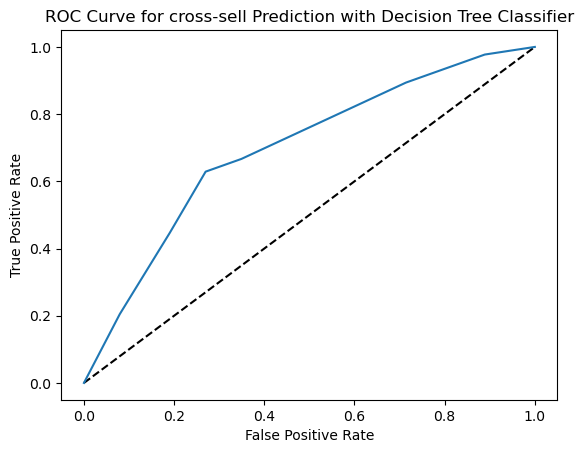

In [24]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for cross-sell Prediction with {model_name}')
plt.show()

### Gradient Boosting Classifier

In [25]:
#Initialize the model
model_name = "Gradient Boosting Classifier"
model = GradientBoostingClassifier(learning_rate = best_params['GradientBoostingClassifier()']['clf__learning_rate'],
                                   max_depth     = best_params['GradientBoostingClassifier()']['clf__max_depth'],
                                   n_estimators  = best_params['GradientBoostingClassifier()']['clf__n_estimators'],
                                   random_state  = 219)

#Fit the models
model_fit = model.fit(X_train, y_train)

#Predict on test data
#model_pred = model_fit.predict(X_test)

# get predicted probabilities
model_y_pred_probs = model_fit.predict_proba(X_test)
probs = model.predict_proba(X_test)[:, 1]

# classify based on adjusted threshold
model_pred = np.where(probs > threshold, 1, 0)

#calculate train and test score, and train-test gap
model_train_score = model_fit.score(X_train, y_train).round(4) # accuracy
model_test_score  = model_fit.score(X_test, y_test).round(4)   # accuracy
model_test_gap = abs(model_train_score - model_test_score).round(4)

# calculate auc score
model_auc = roc_auc_score(y_true  = y_test, y_score = model_pred).round(decimals = 4)

# confusion matrix
# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()

# save model and results in a dictionary in the dictionary "models"
models["gbc"] = {
    "model_type"     : model_name,
    "train_acc"      : model_train_score,
    "test_acc"       : model_test_score,
    "train_test_gap" : model_test_gap,
    "AUC_score"      : model_auc,
    "conf_matrix"    : {
        "tn" : model_tn,
        "fp" : model_fp,
        "fn" : model_fn,
        "tp" : model_tp
    },
    "winner"         : 0
}

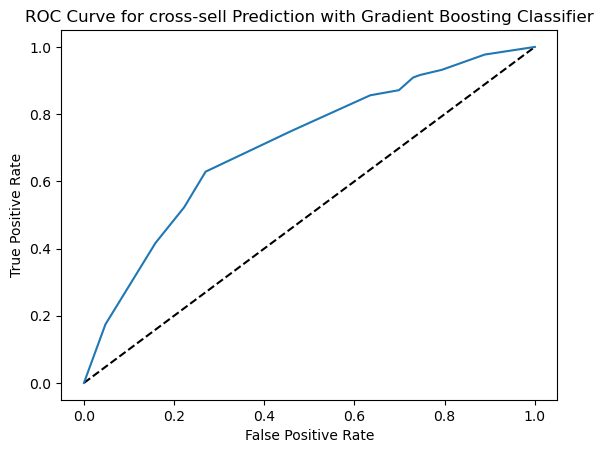

In [26]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for cross-sell Prediction with {model_name}')
plt.show()

### Random Forest Classifier

In [27]:
#Initialize the model
model_name = "Random Forest Classifier"
model = RandomForestClassifier(max_depth    = best_params['RandomForestClassifier()']['clf__max_depth'],
                               n_estimators = best_params['RandomForestClassifier()']['clf__n_estimators'],
                               random_state = 219)

#Fit the models
model_fit = model.fit(X_train, y_train)

#Predict on test data
#model_pred = model_fit.predict(X_test)

# get predicted probabilities
model_y_pred_probs = model_fit.predict_proba(X_test)
probs = model.predict_proba(X_test)[:, 1]

# classify based on adjusted threshold
model_pred = np.where(probs > threshold, 1, 0)

#calculate train and test score, and train-test gap
model_train_score = model_fit.score(X_train, y_train).round(4) # accuracy
model_test_score  = model_fit.score(X_test, y_test).round(4)   # accuracy
model_test_gap = abs(model_train_score - model_test_score).round(4)

# calculate auc score
model_auc = roc_auc_score(y_true  = y_test, y_score = model_pred).round(decimals = 4)

# confusion matrix
# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()

# save model and results in a dictionary in the dictionary "models"
models["rfc"] = {
    "model_type"     : model_name,
    "train_acc"      : model_train_score,
    "test_acc"       : model_test_score,
    "train_test_gap" : model_test_gap,
    "AUC_score"      : model_auc,
    "conf_matrix"    : {
        "tn" : model_tn,
        "fp" : model_fp,
        "fn" : model_fn,
        "tp" : model_tp
    },
    "winner"         : 0
}

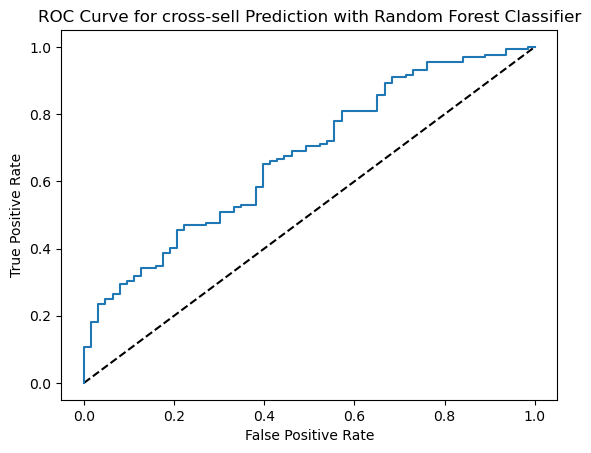

In [28]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for cross-sell Prediction with {model_name}')
plt.show()

### K Neighbors Classifier

In [29]:
#Initialize the model
model_name = "K Neighbors Classifier"
model = KNeighborsClassifier(leaf_size   = best_params['KNeighborsClassifier()']['clf__leaf_size'],
                             n_neighbors = best_params['KNeighborsClassifier()']['clf__n_neighbors'],
                             p           = best_params['KNeighborsClassifier()']['clf__p'],
                             weights     = best_params['KNeighborsClassifier()']['clf__weights'])

#Fit the models
model_fit = model.fit(X_train, y_train)

#Predict on test data
#model_pred = model_fit.predict(X_test)

# get predicted probabilities
model_y_pred_probs = model_fit.predict_proba(X_test)
probs = model.predict_proba(X_test)[:, 1]

# classify based on adjusted threshold
model_pred = np.where(probs > threshold, 1, 0)

#calculate train and test score, and train-test gap
model_train_score = model_fit.score(X_train, y_train).round(4) # accuracy
model_test_score  = model_fit.score(X_test, y_test).round(4)   # accuracy
model_test_gap = abs(model_train_score - model_test_score).round(4)

# calculate auc score
model_auc = roc_auc_score(y_true  = y_test, y_score = model_pred).round(decimals = 4)

# confusion matrix
# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()

# save model and results in a dictionary in the dictionary "models"
models["knc"] = {
    "model_type"     : model_name,
    "train_acc"      : model_train_score,
    "test_acc"       : model_test_score,
    "train_test_gap" : model_test_gap,
    "AUC_score"      : model_auc,
    "conf_matrix"    : {
        "tn" : model_tn,
        "fp" : model_fp,
        "fn" : model_fn,
        "tp" : model_tp
    },
    "winner"         : 0
}

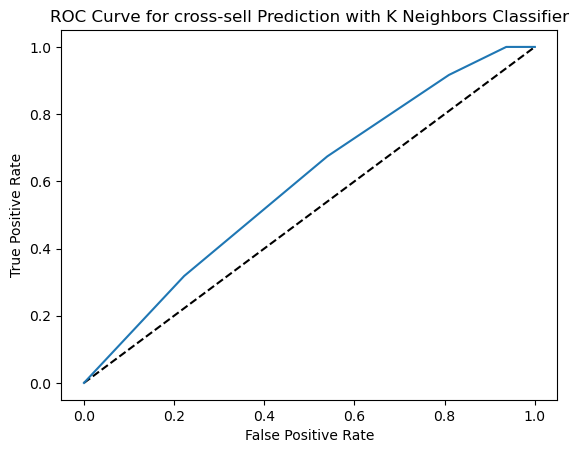

In [30]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, probs)

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for cross-sell Prediction with {model_name}')
plt.show()

## MODEL TOURNAMENT

In [31]:
# initialize the highest AUC score
highest_auc = -1

# find the highest AUC score
for key, value in models.items():
    if value["AUC_score"] > highest_auc:
        highest_auc = value["AUC_score"]
        winner_key = key

# set the winner value of the highest scoring sub-dictionary to 1, and the others to 0
for key, value in models.items():
    if key == winner_key:
        value["winner"] = 1
    else:
        value["winner"] = 0

# CONCLUSION

In [32]:
header = "| {:<10} | {:<30} | {:<15} | {:<15} | {:<15} | {:<15} | {:<40} | {:<10} |".format(
    "Model", "Type", "Train Accuracy", "Test Accuracy", "Train-Test Gap", "AUC Score", "Confusion Matrix", "Winner"
)

print("-" * len(header))
print(header)
print("-" * len(header))

for k, v in models.items():
    model = k
    model_type = v['model_type']
    train_acc = v['train_acc']
    test_acc = v['test_acc']
    train_test_gap = v['train_test_gap']
    auc_score = v['AUC_score']
    winner = v['winner']
    tn = v['conf_matrix']['tn']
    fp = v['conf_matrix']['fp']
    fn = v['conf_matrix']['fn']
    tp = v['conf_matrix']['tp']
    conf_matrix = "tn: {:<3} | fp: {:<3} | fn: {:<3} | tp: {:<3}".format(
    tn, fp, fn, tp
    )
    
    row = "| {:<10} | {:<30} | {:<15} | {:<15} | {:<15} | {:<15} | {:<40} | {:<10} |".format(
        model, model_type, train_acc, test_acc, train_test_gap, auc_score, conf_matrix, winner
    )
    print(row)

print("-" * len(header))

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| Model      | Type                           | Train Accuracy  | Test Accuracy   | Train-Test Gap  | AUC Score       | Confusion Matrix                         | Winner     |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| lrc        | Logistic Regression            | 0.7299          | 0.7179          | 0.012           | 0.6097          | tn: 31  | fp: 32  | fn: 36  | tp: 96     | 0          |
| dtc        | Decision Tree Classifier       | 0.7299          | 0.6974          | 0.0325          | 0.6587          | tn: 41  | fp: 22  | fn: 44  | tp: 88     | 1          |
| gbc        | Gradient Boosting Classifier   | 0.7276          | 0.6974          | 0.0302          | 0.6106          | 